In [23]:
import itertools
import os
from pathlib import Path

for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

from matplotlib.figure import Figure
from matplotlib.patches import Patch
from matplotlib.transforms import Bbox

from os.path import basename

from toolz import merge, identity, compose_left, keyfilter

from sklearn.calibration import calibration_curve
from functional import pipe, or_fn

from functools import partial
from typing import Callable, Iterable, Mapping
from nested_cv import get_cv_results_from_simple_cv_evaluation

from notebooks.heart_transplant.dependencies.heart_transplant_functions import format_feature, \
    format_heart_transplant_method_name, get_feature_metadata, present_table_base
from scripts.feature_importance import plot_feature_importance_formatted


from matplotlib import pyplot
from pandas import Series

from visualisation import plot_roc_from_result, display_html, savefig, display_dict_as_table_horizontal, sort_legend

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import itertools
import os
from pathlib import Path
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break


from notebooks.heart_transplant.heart_transplant_evaluate_results import HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, \
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER

import shelve
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata

from evaluation_functions import  join_folds_cv_result, \
    ModelResult, get_1_class_y_score, join_repeats_and_folds_cv_results
from formatting import  b
from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached

pyplot.style.use('default')

PUBLISH_FOLDER  = './data/heart_transplant/publish'
# PUBLISH_FOLDER  = '/home/sitnarf/OneDrive/Shared ML in CV health/UNOS analysis/Figures/Export'
DEFAULT_FIGURE_SIZE = (6, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)

[Memory]14518.3s, 242.0min: Loading get_reduced_binary_dataset...
[Memory]14525.8s, 242.1min: Loading get_reduced_binary_dataset...


In [25]:
with shelve.open(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL', flag='r') as data:
    print(list(data.keys()))


['random_forest_tuned', 'xgboost_tuned', 'l2_logistic_regression_tuned', 'l2_logistic_regression_default', 'l2_logistic_regression_default_old', 'xgboost_default', 'random_forest_default']


In [26]:
def present_table(file_name: str, *args, **kwargs) -> None:
    results = shelve.open(file_name, flag='r')
    b('Default')
    present_table_base(results, *args, include_delta=False, format_method_name=format_heart_transplant_method_name, filter_callback=default_filter, **kwargs)
    b('Optimized')
    present_table_base(results, *args, include_delta=False, format_method_name=format_heart_transplant_method_name, filter_callback=tuned_filter, **kwargs)

def present_rocs(*args, **kwargs) -> None:
    present_rocs_base(
        *args,
        filter_callback=or_fn(tuned_filter),
        style_by_callback=[color_methods_colorblind],
        format_method_name=format_heart_transplant_method_name,
        format_file_name=lambda file_name: file_name+'_optimized',
        **kwargs,
    )

def present_rocs_base(
        file_name: str,
        y: Series,
        filter_callback: Callable[[str], bool],
        style_by_callback: Iterable[Callable[[str], Mapping]] = None,
        format_method_name: Callable[[str], str] = identity,
        format_file_name: Callable[[str], str] = identity,
        figure: Figure = None,
        display_random_curve: bool = True,
) -> None:

    if not figure:
        pyplot.figure(figsize=DEFAULT_FIGURE_SIZE)

    style_by_callback = style_by_callback if style_by_callback is not None else {}

    results = shelve.open(file_name, flag='r')

    sorted_results = pipe(
        results.items(),
        partial(sorted, key=lambda i: i[1]['chosen']['metrics']['roc_auc'][0], reverse=True)
    )

    for method_name, item in sorted_results:
        if filter_callback is None or filter_callback(method_name):
            style = merge(*[callback(method_name) for callback in style_by_callback], {})
            plot_roc_from_result(y,item['chosen']['result'], label=format_method_name(method_name), plot_kwargs=style, display_random_curve=display_random_curve)

    pyplot.gca().xaxis.label.set_fontsize(13)
    pyplot.gca().xaxis.labelpad = 5
    pyplot.gca().yaxis.label.set_fontsize(13)
    pyplot.gca().yaxis.labelpad = 7

    pyplot.grid(alpha=0.5, linestyle='--', linewidth=0.75)


    try:
        sort_legend(pyplot.gca())
    except ValueError:
        pass

    if not figure:
        pyplot.show()

    results.close()


def tuned_filter(key: str) -> bool:
    return key.endswith('tuned')

def default_filter(key: str) -> bool:
    return key.endswith('default')

def expert_filter(key: str) -> bool:
    return 'expert' in key

def color_methods(key: str) -> Mapping:
    colors = pyplot.get_cmap('Paired').colors
    if 'xgboost' in key:
        index = 1
    elif 'random_forest' in key:
        index= 3
    elif 'l2_logistic_regression' in key:
        index = 5
    else:
        index = 1

    if 'default' in key:
        index -= 1

    return {'color': colors[index]}

def color_methods_colorblind(key: str) -> Mapping:
    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    if 'xgboost' in key:
        index = 0
    elif 'random_forest' in key:
        index= 1
    elif 'ridge' in key:
        index = 3
    else:
        index = 2

    return {'color': colors[index]}

def dashed_style(_: str) -> Mapping:
    return {'linestyle': '--'}


## Overview ROCs

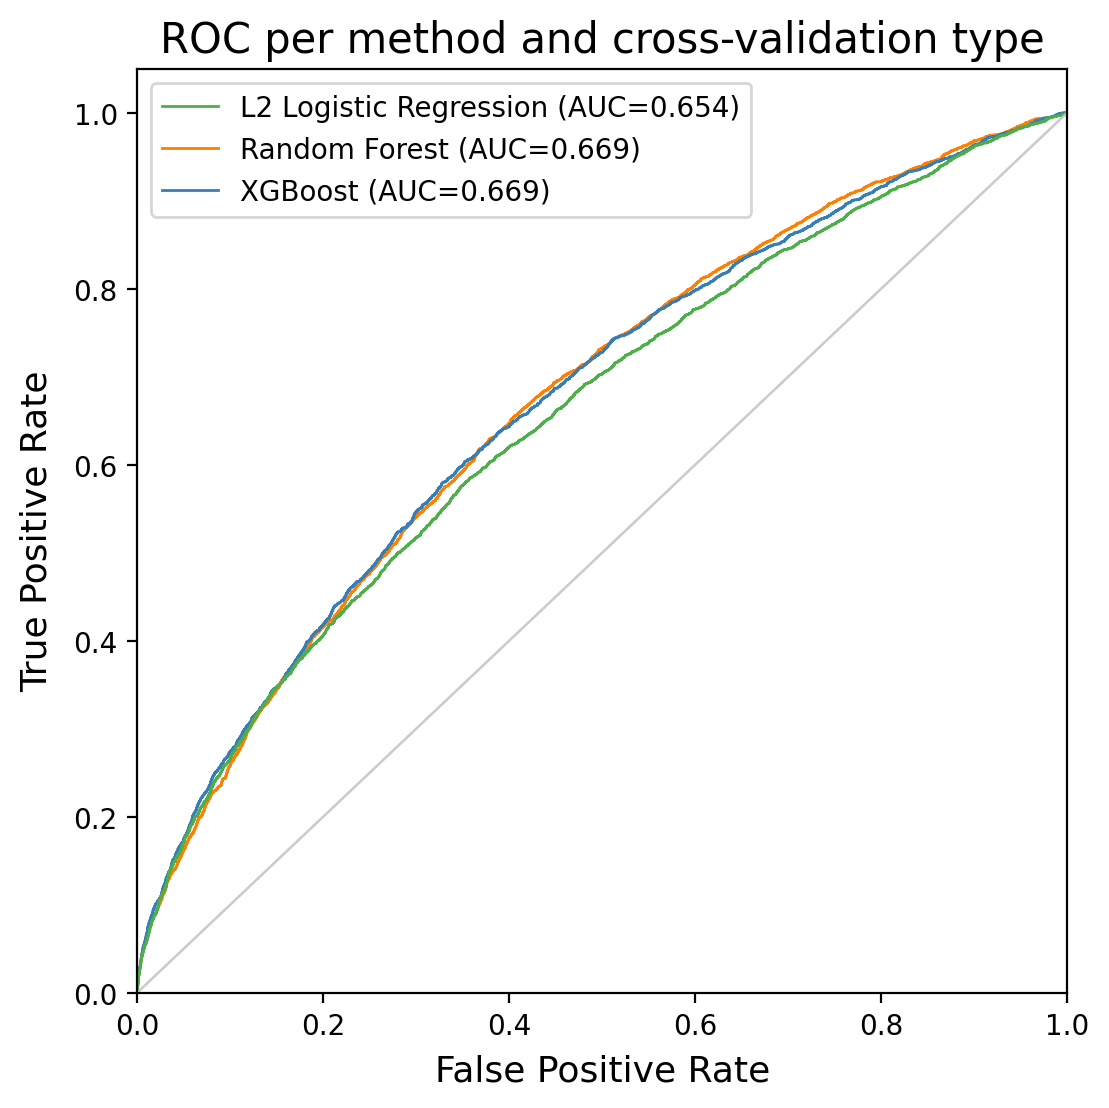

In [27]:
figure_abstract = pyplot.figure(figsize=(6,6))

present_rocs_base(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL',
    y_365,
    filter_callback=tuned_filter,
    figure=figure_abstract,
    style_by_callback=[color_methods_colorblind],
    format_method_name=format_heart_transplant_method_name,
    format_file_name=lambda file_name: file_name+'_optimized',
)
present_rocs_base(
    HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER,
    y_365,
    filter_callback=tuned_filter,
    figure=figure_abstract,
    style_by_callback=[color_methods_colorblind, dashed_style],
    format_method_name=compose_left(format_heart_transplant_method_name, lambda name: name+' Shuffled'),
    format_file_name=lambda file_name: file_name+'_optimized',
)

pyplot.title('ROC per method and cross-validation type')
pyplot.gca().title.set_fontsize(15)
# pyplot.gca().title.set_position([.5, 1.5])
savefig(PUBLISH_FOLDER+'/roc_overview.svg')
savefig(PUBLISH_FOLDER+'/roc_overview.png')

## Shuffled CV

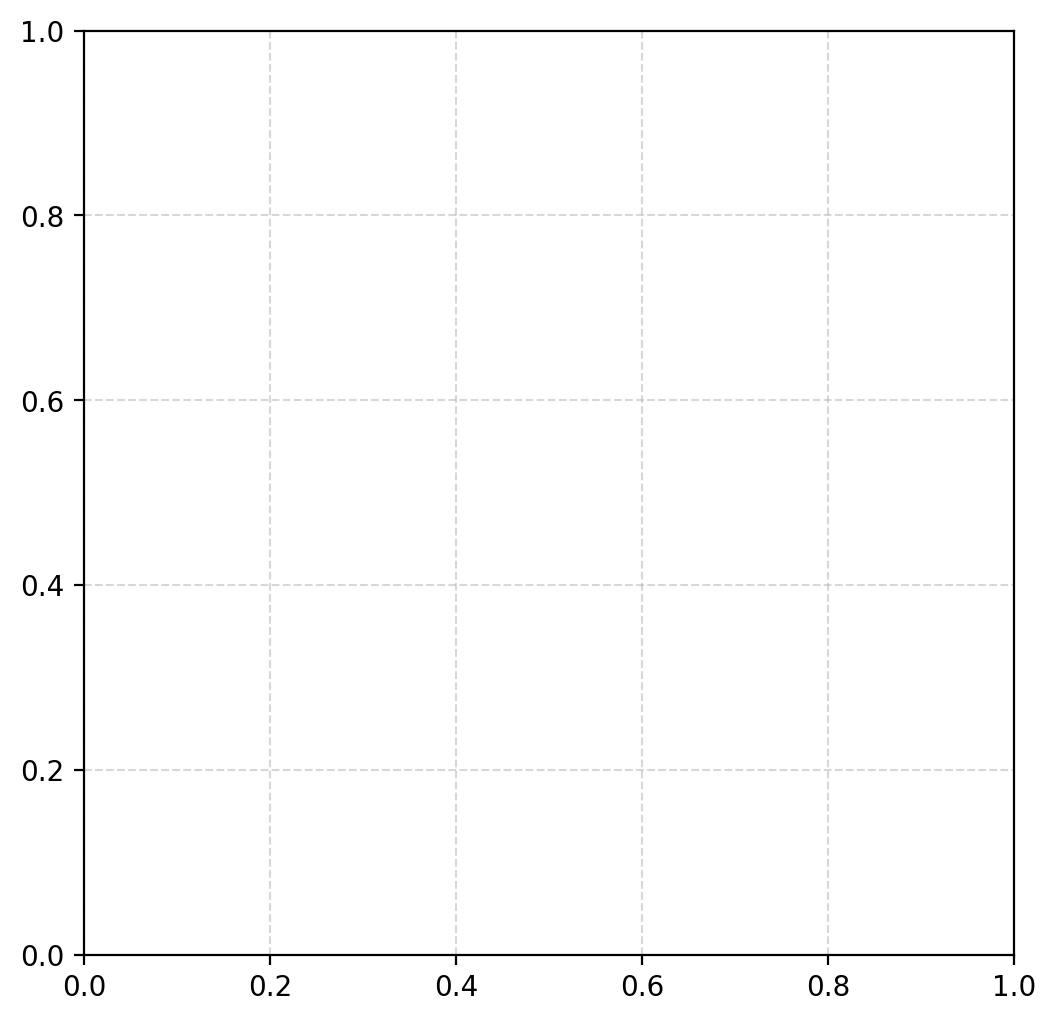

In [28]:
present_table(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, y_365)
print()
present_rocs(
    HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER,
    y_365,
)

## Expanding window

### 365 days

#### All age groups


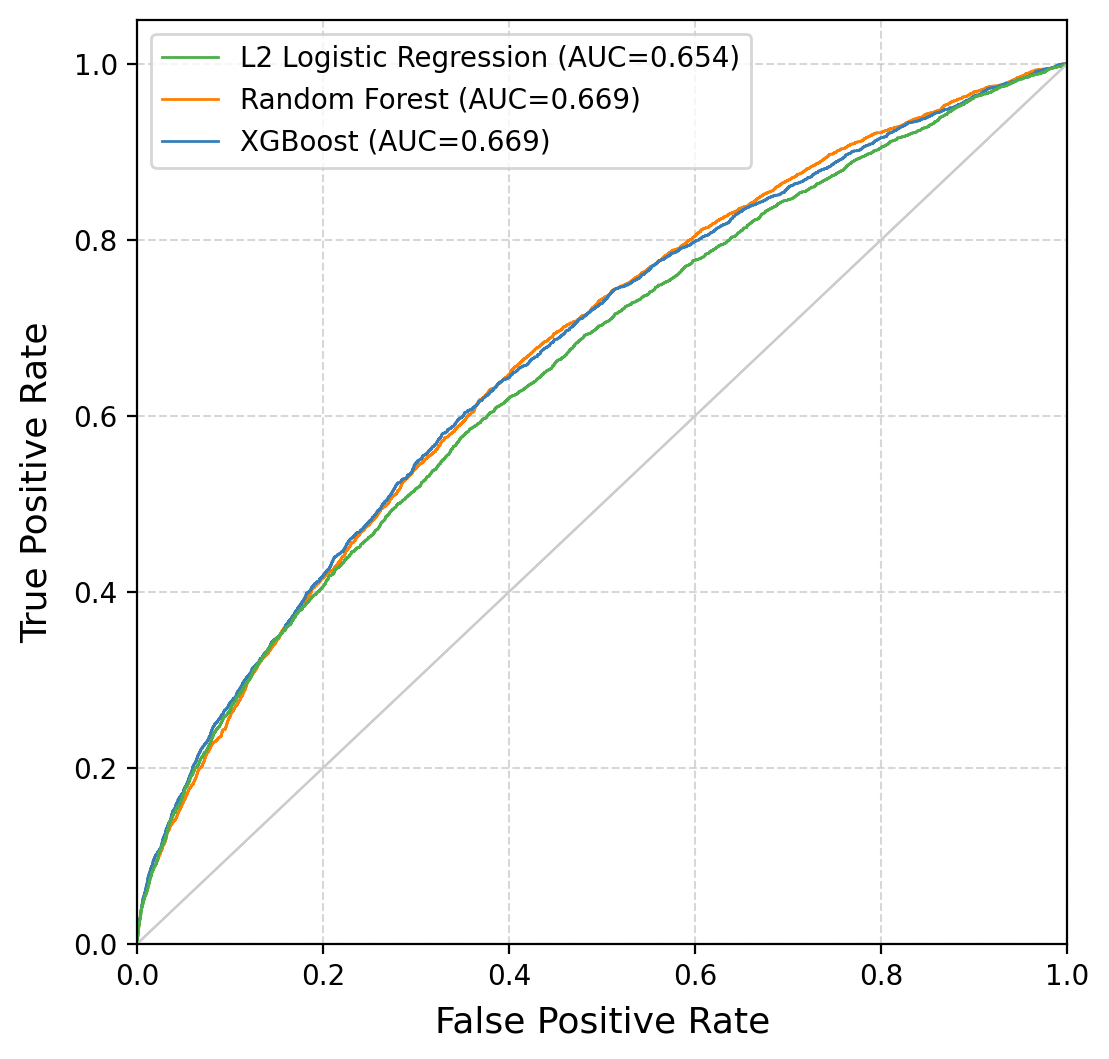

In [29]:
present_table(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL', y_365)
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL',
    y_365,
)

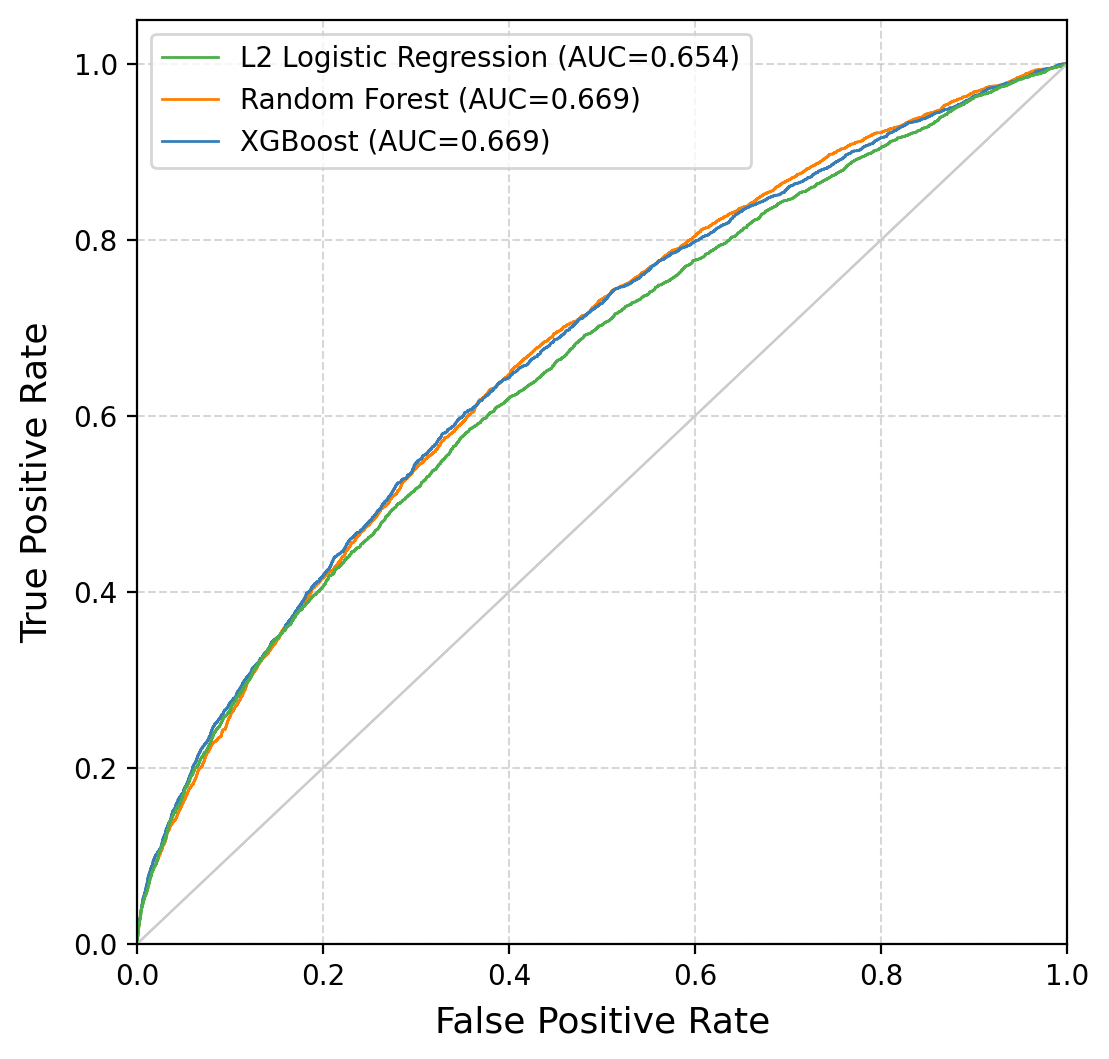

In [30]:
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL',
    y_365,
)


#### < 18 years old

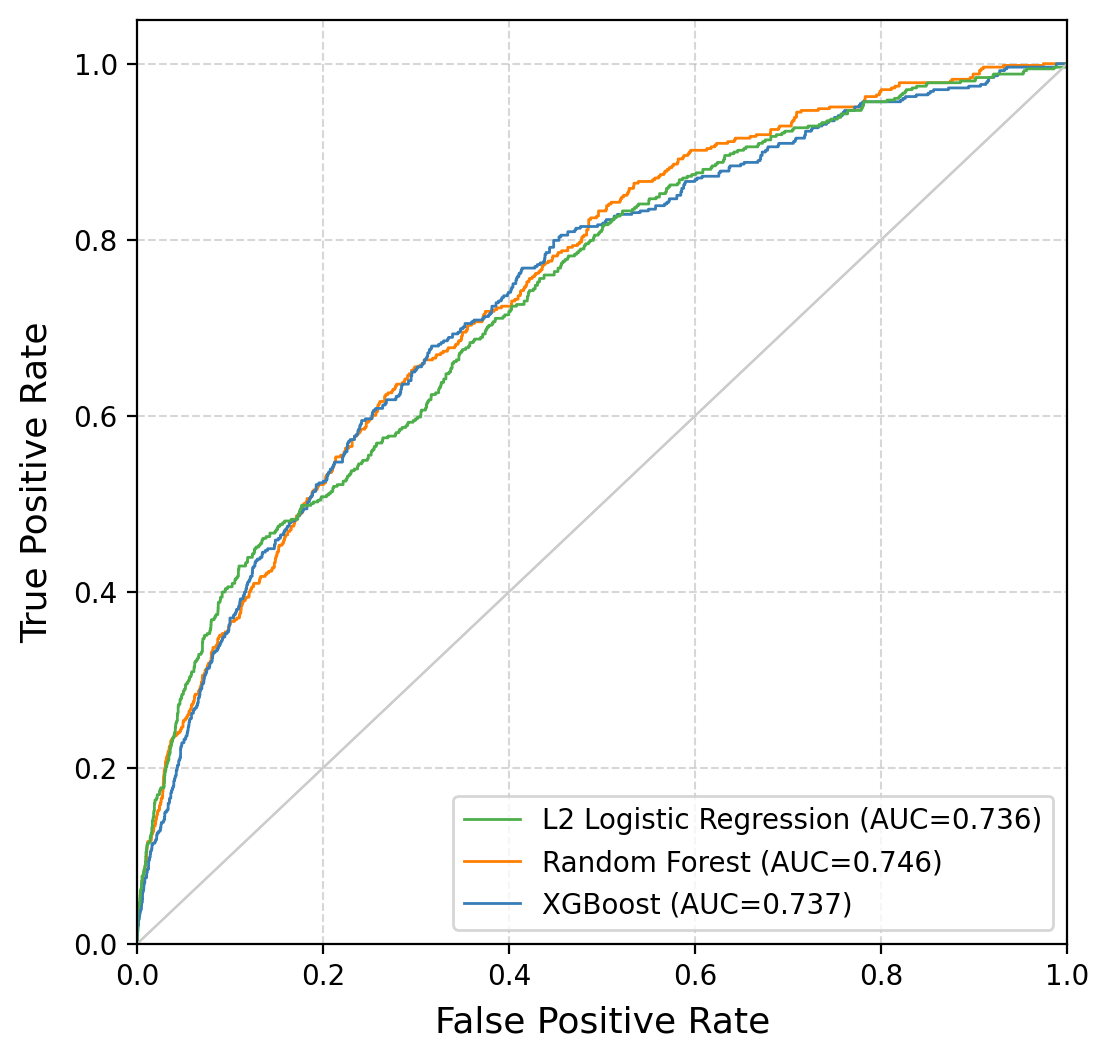

In [31]:
present_table(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18', y_365)
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18',
    y_365,
)

#### >= 18 years old

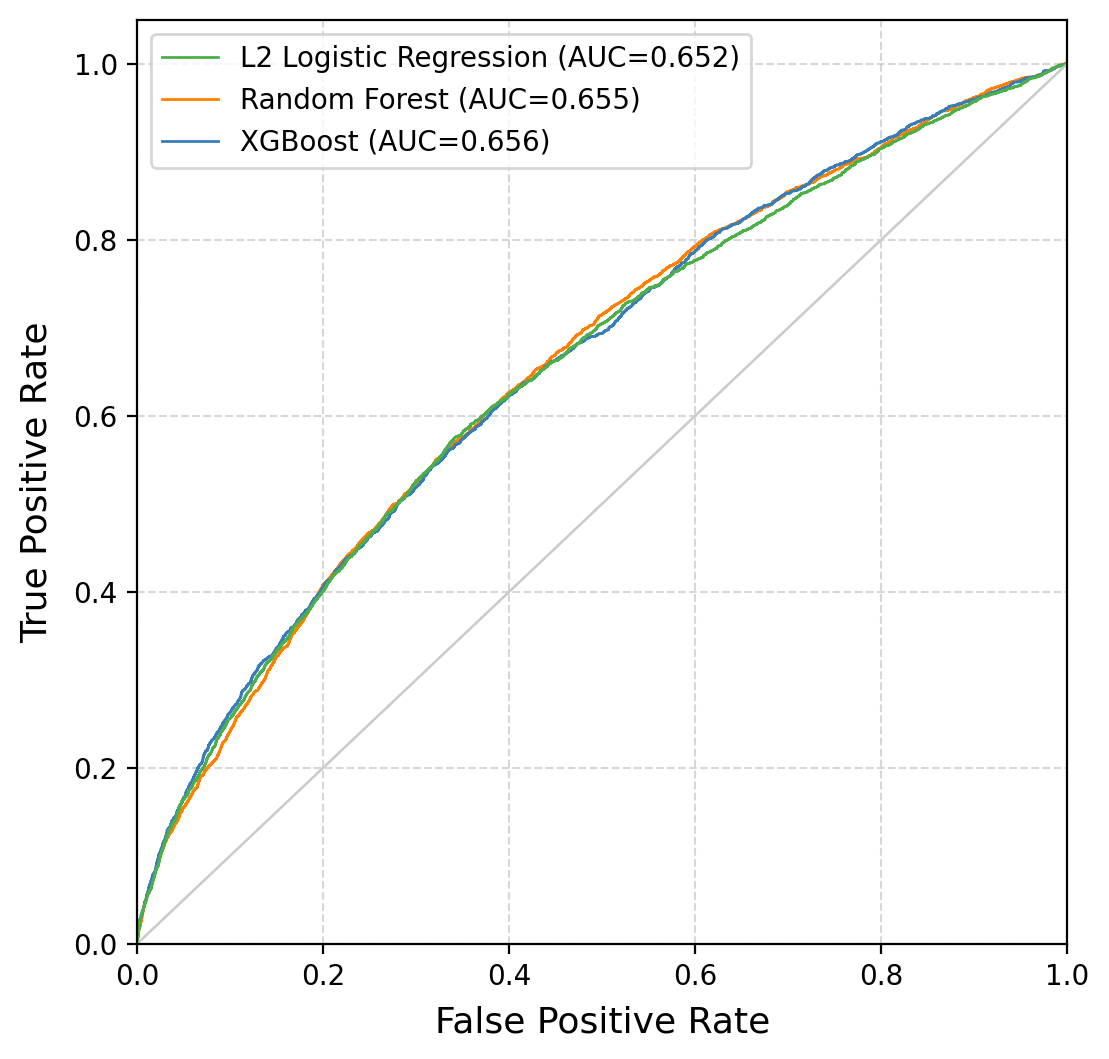

In [32]:
present_table(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ME_18', y_365)
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ME_18',
    y_365,
)


### 90 days

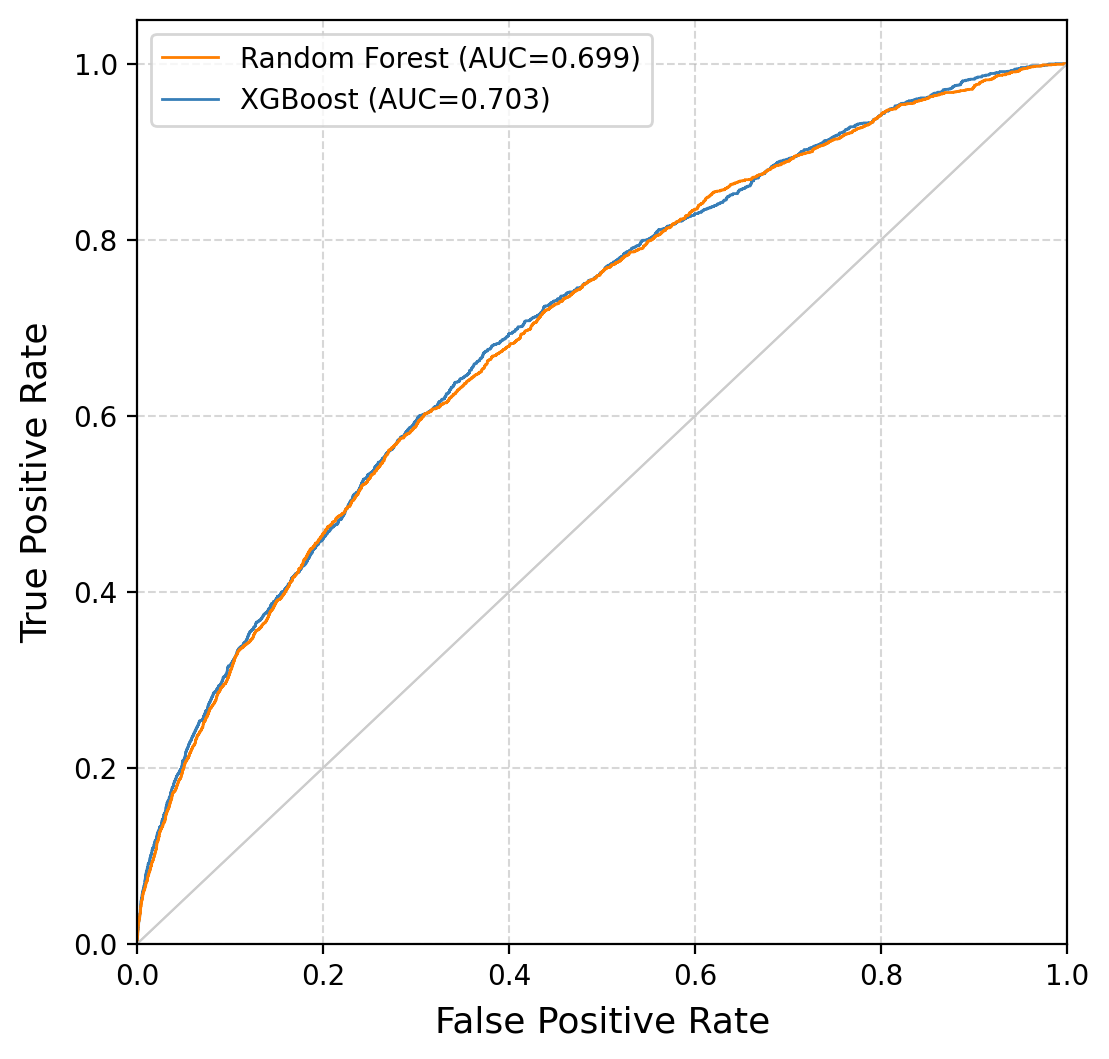

In [33]:
present_table(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_ALL', y_90)
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_ALL',
    y_90,
)

# Calibration plots

## Shuffled CV

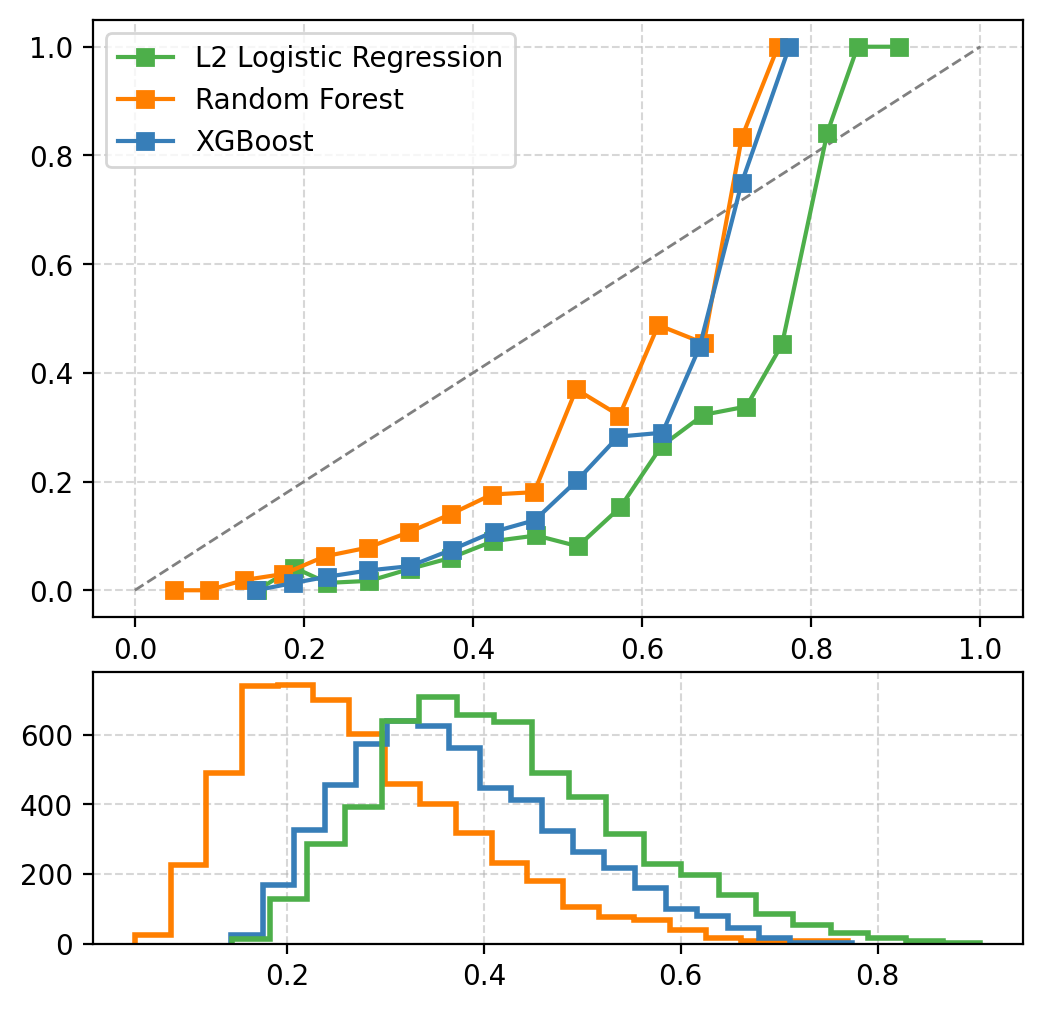

In [34]:
def present_calibration_plots(
        file_name: str,
        y: Series,
        filter_callback: Callable[[str], bool] = None,
        style_by_callback: Iterable[Callable[[str], Mapping]] = None
) -> None:
    results = shelve.open(file_name, flag='r')
    fig = pyplot.figure(1, figsize=(6, 6))
    ax1 = pyplot.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = pyplot.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    for method, item in sorted(results.items(), key=lambda i: i[0]):
        if filter_callback is None or filter_callback(method):
            style = merge(*[callback(method) for callback in style_by_callback], {})
            result_joined: ModelResult = join_folds_cv_result(item['chosen']['result'])

            fraction_of_positives, mean_predicted_value  = calibration_curve(
                y.loc[result_joined['y_test_score'].index], get_1_class_y_score(result_joined['y_test_score']),
                n_bins=20
            )

            ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=format_heart_transplant_method_name(method), **style)

    ax1.legend()

    for method, item in results.items():
        if filter_callback is None or filter_callback(method):
            result_joined: ModelResult = join_folds_cv_result(item['chosen']['result'])
            style = merge(*[callback(method) for callback in style_by_callback], {})

            ax2.hist(
                get_1_class_y_score(result_joined['y_test_score']),
                bins=20,
                label=method,
                histtype="step",
                lw=2,
                **style
            )
    ax1.grid(alpha=0.5, linestyle='--', linewidth=0.75)
    ax2.grid(alpha=0.5, linestyle='--', linewidth=0.75)
    savefig(PUBLISH_FOLDER+f'/calibration/{basename(file_name)}.svg')
    fig.show()

    results.close()

present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18', y_365, filter_callback=or_fn(tuned_filter), style_by_callback=[color_methods_colorblind])

## Expanding window

### 365 days

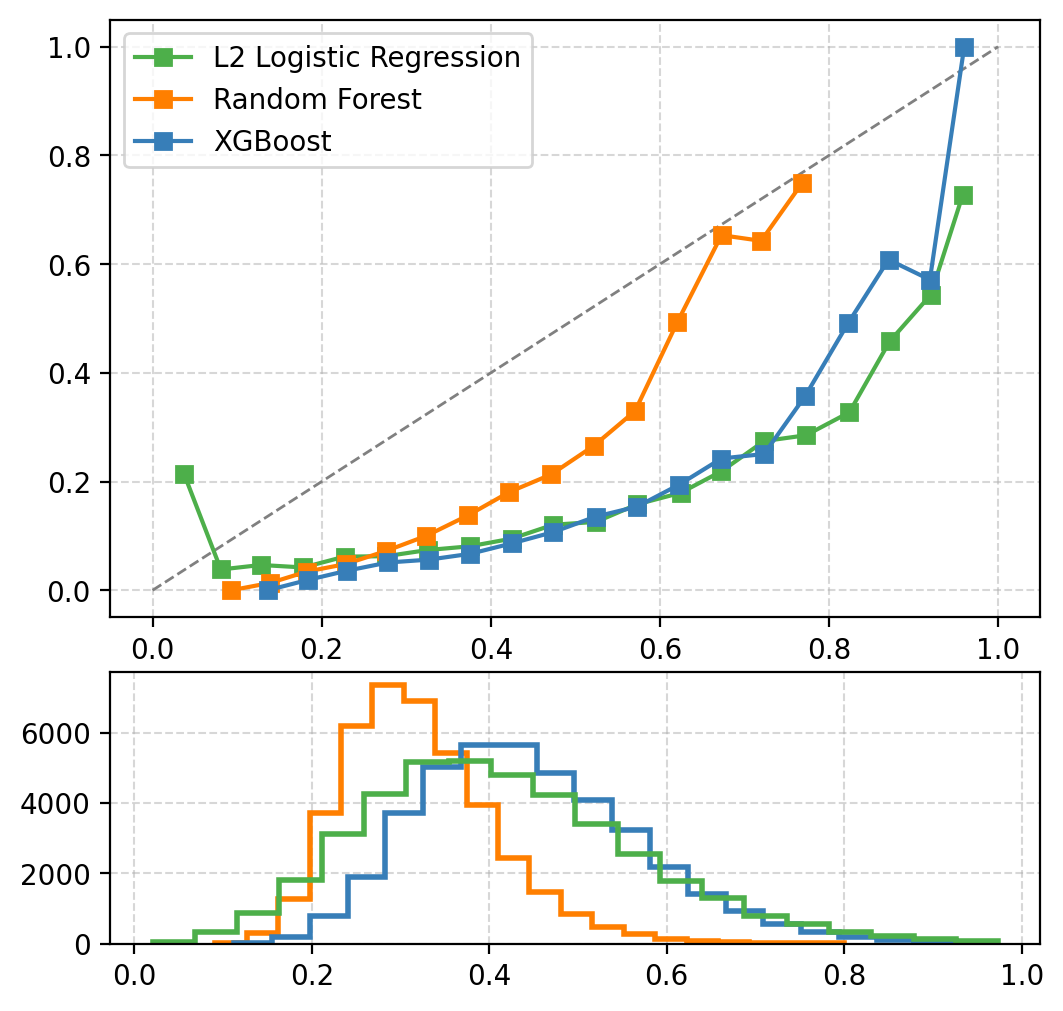

In [35]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL', y_365, filter_callback=or_fn(tuned_filter), style_by_callback=[color_methods_colorblind])


#### All age groups

#### < 18 years old

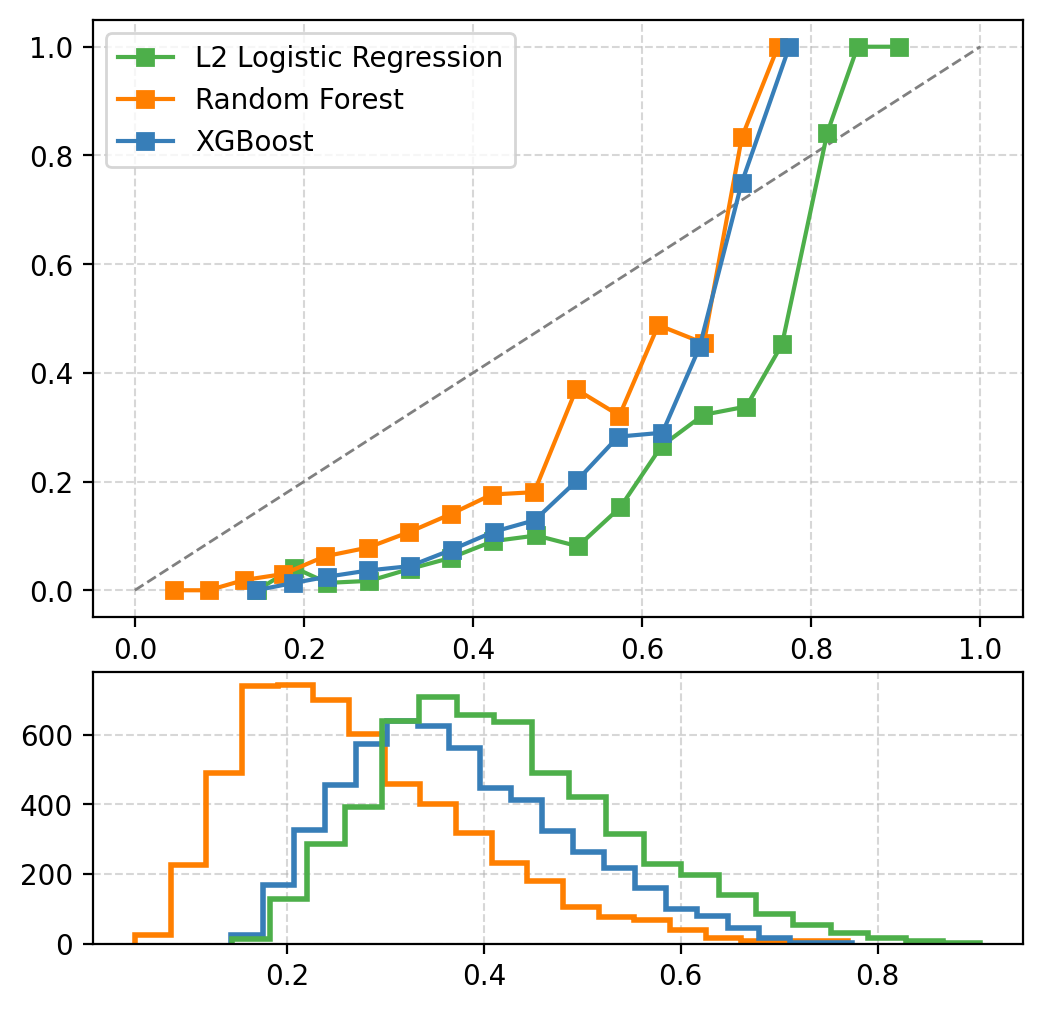

In [36]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18', y_365, filter_callback=or_fn(tuned_filter), style_by_callback=[color_methods_colorblind])

#### >= 18 years old

In [37]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', y_365, filter_callback=or_fn(tuned_filter), style_by_callback=[color_methods_colorblind])

error: db file doesn't exist; use 'c' or 'n' flag to create a new db

### 90 days

In [ ]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_all', y_90, filter_callback=or_fn(tuned_filter, default_filter), style_by_callback=[color_methods])

# Feature importance

In [ ]:
def present_feature_importance(file_name: str, filter_callback: Callable[[str], bool] = None, n_features: int=30, format_method_name: Callable[[str], str] = identity) -> None:
    with shelve.open(file_name, flag='r') as results:
        results_filtered = keyfilter(lambda _name: filter_callback is None or filter_callback(_name), results)
        n_items = len(results_filtered)
        fig, ax = pyplot.subplots(n_items, figsize=(2.5, n_items*7))

        for i, (name, item) in enumerate(results_filtered.items()):
                current_axis = ax[i]
                t = current_axis.set_title(format_method_name(name), loc='center', pad=10)

                cv_results = get_cv_results_from_simple_cv_evaluation([item])

                colors_per_feature_type = {
                    'recipient': '#377eb8',
                    'donor': '#ff7f00',
                    'matching': '#4daf4a',
                }

                try:
                    plot_feature_importance_formatted(
                        cv_results,
                        format_feature=lambda feature_name: pipe(
                            feature_name,
                            partial(format_feature, metadata),
                        ),
                        n_features=n_features,
                        axis=current_axis,
                        bar_color_callback=lambda identifier, row: colors_per_feature_type[get_feature_metadata(identifier, metadata)['type']],
                    )

                    current_axis.grid(
                        linestyle='--', which='major', color='#93939c', alpha=0.6, linewidth=0.75, axis='y'
                    )

                    current_axis.legend(
                        handles=[
                            Patch(color=color, label=feature_type.capitalize()) for feature_type, color in colors_per_feature_type.items()
                        ],
                        loc='lower right',
                    )
                except:
                    ...
                def full_extent(ax, pad=0.0):
                    """Get the full extent of an axes, including axes labels, tick labels, and
                    titles."""
                    # For text objects, we need to draw the figure first, otherwise the extents
                    # are undefined.
                    ax.figure.canvas.draw()
                    items = ax.get_xticklabels() + ax.get_yticklabels()
                #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
                    items += [ax, ax.title]
                    bbox = Bbox.union([item.get_window_extent() for item in items])
                    return bbox.expanded(1.0 + pad, 1.0 + pad)

                # extent = full_extent(current_axis).transformed(fig.dpi_scale_trans.inverted())
                # Alternatively,
                # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())


        savefig(PUBLISH_FOLDER+f'/feature_importance/{basename(file_name)}.svg')
        pyplot.tight_layout()



def get_top_features(file_name: str, n_features: int, filter_callback: Callable[[str], bool] = None):
    with shelve.open(file_name, flag='r') as results:
        for name, item in results.items():
            if filter_callback is None or filter_callback(name):
                cv_results = get_cv_results_from_simple_cv_evaluation([item])
                model_result = join_repeats_and_folds_cv_results(cv_results)
                print(name)
                print(list(model_result['feature_importance'].index[:n_features]))
                print()

present_feature_importance(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, filter_callback=tuned_filter, format_method_name=format_heart_transplant_method_name)

## Shuffled CV

In [ ]:

# get_top_features(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, n_features=10)

## Expanding window

### 365 days

#### All age groups

In [ ]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL', filter_callback=tuned_filter)

#### < 18 years old

In [ ]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18', filter_callback=tuned_filter)


#### >= 18 years old

In [ ]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', filter_callback=tuned_filter)


### 90 days

In [ ]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+"_90_all", filter_callback=tuned_filter)



# Chosen hyperparameters

In [ ]:
def present_chosen_hyperparameters(file_name: str, filter_callback: Callable = None, pretty: bool = True) -> None:

    results = shelve.open(file_name, flag='r')

    for name, item in results.items():
        if filter_callback is None or filter_callback(name) is True:
            b(name)
            try:
                hyperparameters = item['chosen']['configuration']['classifier']
            except KeyError:
                display_html('<p>No configuration</p>')
            else:
                if pretty:
                    display_dict_as_table_horizontal(hyperparameters)
                else:
                    print(hyperparameters)

            print()

## Shuffled CV

In [ ]:
present_chosen_hyperparameters(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, filter_callback=tuned_filter, pretty=True)

## Expanding window

### 365 days

#### All age groups

In [ ]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_ALL', filter_callback=tuned_filter, pretty=True)

#### < 18 years old

In [ ]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_L_18', filter_callback=tuned_filter, pretty=True)

#### >= 18 years old

In [ ]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', filter_callback=tuned_filter, pretty=True)

### 90 days

In [ ]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_all', filter_callback=tuned_filter, pretty=True)
